In [148]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from numba import njit
import networkx as nx

In [149]:
def calcular_variancia_ruido(Eb_N0_dB):
    Eb_N0 = 10**(Eb_N0_dB / 10)
    N0 = 1 / Eb_N0
    sigma2 = N0 / 2
    return sigma2

In [150]:
def gerar_simbolos_bpsk(num_bits):
    return np.random.choice([-1, 1], num_bits)

In [151]:
def adicionar_ruido_gaussiano(simbolos, sigma2):
    sigma = np.sqrt(sigma2)
    ruido = sigma * np.random.randn(len(simbolos))
    r = simbolos + ruido
    return r

In [152]:
def calcular_valor_recebido(simbolos, Eb_N0_dB):
    sigma2 = calcular_variancia_ruido(Eb_N0_dB)
    r = adicionar_ruido_gaussiano(simbolos, sigma2)
    return r

In [153]:
def calcular_valores_llr(r, sigma2):
    llr = 2 * r / sigma2
    return llr

In [154]:
@njit
def generate_LDPC_matrix(N, dv, dc, K, M):
    H1 = np.zeros((K, N), dtype=np.int32)
    for i in range(len(H1)):
        H1[i][i * dc:(i + 1) * dc] = 1

    H = H1

    for _ in range(dv - 1):
        perm = np.random.permutation(N)
        H2 = H1[:, perm]
        H = np.concatenate((H, H2), axis=0)

    return H

In [155]:
def inicializar_mensagens(Lc, H):
    num_cnodes, num_vnodes = H.shape
    Le = np.zeros((num_cnodes, num_vnodes))  # Mensagens dos c-nodes para os v-nodes
    Lr = np.zeros((num_cnodes, num_vnodes))  # Mensagens dos v-nodes para os c-nodes
    return Le, Lr

In [156]:
# Parâmetros de exemplo
num_bits = 1000
Eb_N0_dB = 3.0

# Gerar símbolos BPSK
simbolos = gerar_simbolos_bpsk(num_bits)

# Calcular valores recebidos com ruído
r = calcular_valor_recebido(simbolos, Eb_N0_dB)

# Calcular valores LLR
sigma2 = calcular_variancia_ruido(Eb_N0_dB)
Lc = calcular_valores_llr(r, sigma2)

# Exemplo de matriz de verificação de paridade H
H = np.array([
    [1, 0, 1, 1, 0, 0],
    [0, 1, 0, 1, 1, 0],
    [0, 0, 1, 0, 1, 1]
])

# Inicializar as mensagens de entrada
Le, Lr = inicializar_mensagens(Lc, H)

In [157]:
def atualizar_mensagens_vnodes(Lc, Le, H):
    num_cnodes, num_vnodes = H.shape
    Lr = np.zeros((num_cnodes, num_vnodes))  # Inicializar Lr corretamente
    for i in range(num_vnodes):
        for j in range(num_cnodes):
            if H[j, i] == 1:
                Lr[j, i] = Lc[i] + np.sum(Le[:, i]) - Le[j, i]
    return Lr


In [158]:
def atualizar_mensagens_cnodes(Lr, H):
    num_cnodes, num_vnodes = H.shape
    Le = np.zeros((num_cnodes, num_vnodes))  # Inicializar Le corretamente
    for j in range(num_cnodes):
        for i in range(num_vnodes):
            if H[j, i] == 1:
                produtos = np.prod(np.tanh(Lr[j, :] / 2))
                produtos /= np.tanh(Lr[j, i] / 2)
                Le[j, i] = 2 * np.arctanh(produtos)
    return Le


In [159]:
def ldpc_decode(Lc, H, max_iter=50):
    num_cnodes, num_vnodes = H.shape
    Le, Lr = inicializar_mensagens(Lc, H)
    
    for iteration in range(max_iter):
        # Atualizar mensagens dos v-nodes
        Lr = atualizar_mensagens_vnodes(Lc, Lr, H)
        
        # Atualizar mensagens dos c-nodes
        Le = atualizar_mensagens_cnodes(Lr, H)
        
        # Critério de parada: verificar se todas as equações de paridade são satisfeitas
        decision = np.sign(Lc + np.sum(Le, axis=0))
        if np.all(np.mod(np.dot(H, decision), 2) == 0):
            break

    # Decisão final
    Lf = Lc + np.sum(Le, axis=0)
    decoded_bits = np.sign(Lf)
    return decoded_bits

In [160]:
def ldpc_decode(Lc, H, max_iter=50):
    Le, Lr = inicializar_mensagens(Lc, H)
    
    for iteration in range(max_iter):
        # Atualizar mensagens dos v-nodes
        Lr = atualizar_mensagens_vnodes(Lc, Le, H)
        
        # Atualizar mensagens dos c-nodes
        Le = atualizar_mensagens_cnodes(Lr, H)
        
        # Critério de parada: verificar se todas as equações de paridade são satisfeitas
        decision = np.sign(Lc[:Le.shape[1]] + np.sum(Le, axis=0))
        if np.all(np.mod(np.dot(H, decision), 2) == 0):
            break

    # Decisão final
    Lf = Lc[:Le.shape[1]] + np.sum(Le, axis=0)
    decoded_bits = np.sign(Lf)
    return decoded_bits


In [161]:
def calcular_ber(bits_originais, bits_decodificados):
    # Certificar-se de que ambos os arrays tenham o mesmo tamanho
    min_length = min(len(bits_originais), len(bits_decodificados))
    bits_originais = bits_originais[:min_length]
    bits_decodificados = bits_decodificados[:min_length]
    
    erros = np.count_nonzero(bits_originais != bits_decodificados)
    ber = erros / len(bits_originais)
    return ber

In [162]:
def simular_desempenho_ldpc(H, num_bits, Eb_N0_dB_range, max_iter=50):
    ber_results = []
    
    for Eb_N0_dB in Eb_N0_dB_range:
        # Gerar símbolos BPSK
        simbolos = gerar_simbolos_bpsk(num_bits)
        
        # Calcular valores recebidos com ruído
        r = calcular_valor_recebido(simbolos, Eb_N0_dB)
        
        # Calcular valores LLR
        sigma2 = calcular_variancia_ruido(Eb_N0_dB)
        Lc = calcular_valores_llr(r, sigma2)
        
        # Decodificar
        bits_decodificados = ldpc_decode(Lc, H, max_iter=max_iter)
        
        # Calcular BER
        ber = calcular_ber(simbolos, bits_decodificados)
        ber_results.append(ber)
        
    return ber_results

In [163]:
@njit
def set_params(N, dv, dc):
    if N % dc != 0:
        raise ValueError("N must be divisible by dc")
    else:
        K = int(N / dc)
        M = int(K * dv)
        return (K, M)

In [164]:
@njit
def generate_LDPC_matrix(N, dv, dc, K, M):
    H1 = np.zeros((K, N), dtype=np.int32)
    for i in range(len(H1)):
        H1[i][i * dc:(i + 1) * dc] = 1

    H = H1

    for _ in range(dv - 1):
        perm = np.random.permutation(N)
        H2 = H1[:, perm]
        H = np.concatenate((H, H2), axis=0)

    return H

In [165]:
# Definindo os parâmetros para simulação
num_bits = 1000
Eb_N0_dB_range = np.arange(0, 5.5, 0.5)

In [166]:
# Gerando a matriz LDPC
N = 999
dv = 4
dc = 9
K, M = set_params(N, dv, dc)
H = generate_LDPC_matrix(N, dv, dc, K, M)

In [167]:
# Simulando o desempenho
ber_results = simular_desempenho_ldpc(H, num_bits, Eb_N0_dB_range)

In [168]:
def plotar_ber(Eb_N0_dB_range, ber_results):
    plt.figure(figsize=(10, 6))
    plt.plot(Eb_N0_dB_range, ber_results, marker='o', linestyle='-', color='b')
    plt.yscale('log')
    plt.xlabel('Eb/N0 (dB)')
    plt.ylabel('Taxa de Erro de Bit (BER)')
    plt.title('Desempenho do Código LDPC')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

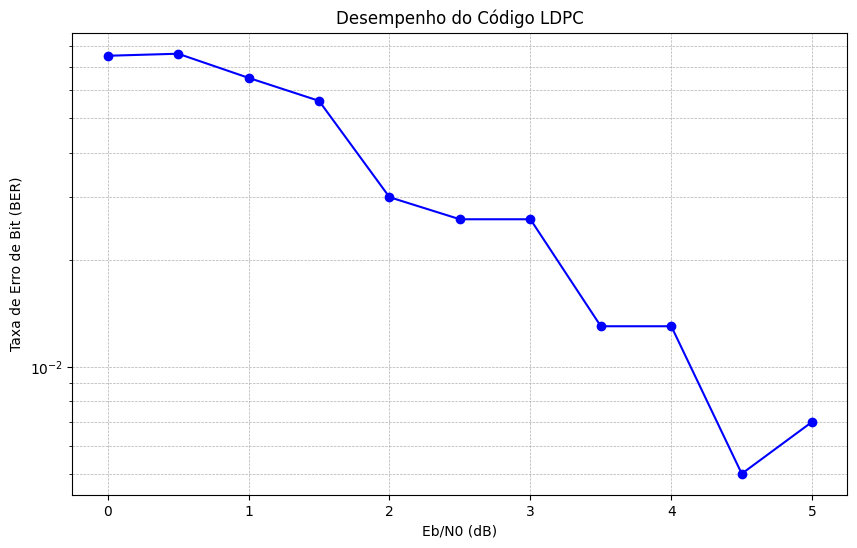

In [169]:
# Plotar o gráfico
plotar_ber(Eb_N0_dB_range, ber_results)

In [170]:
def encontrar_menor_eb_n0(ber_results, Eb_N0_dB_range, threshold=1e-4):
    for Eb_N0_dB, ber in zip(Eb_N0_dB_range, ber_results):
        if ber < threshold:
            return Eb_N0_dB
    return None

# Encontrar o menor valor de Eb/N0 para BER < 10^-4
menor_eb_n0 = encontrar_menor_eb_n0(ber_results, Eb_N0_dB_range)
print(f"Menor valor de Eb/N0 para BER < 10^-4: {menor_eb_n0} dB")

Menor valor de Eb/N0 para BER < 10^-4: None dB


In [171]:
import csv

def gerar_grafo_csv(H, filename='grafo_ldpc.csv'):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        for row in H:
            indices = np.where(row == 1)[0]
            writer.writerow(indices)

# Exemplo de matriz H para N ≈ 1000
H = generate_LDPC_matrix(N, dv, dc, K, M)

# Gerar arquivo CSV
gerar_grafo_csv(H)